In [1]:
import pandas as pd
import numpy as np
import csv
from cProfile import label
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
with open('T_T100D_SEGMENT_US_CARRIER_ONLY.csv', 'r') as file:
    df1 = pd.read_csv(file)
df1.columns

Index(['DEPARTURES_SCHEDULED', 'DEPARTURES_PERFORMED', 'PAYLOAD', 'SEATS',
       'PASSENGERS', 'FREIGHT', 'MAIL', 'DISTANCE', 'RAMP_TO_RAMP', 'AIR_TIME',
       'UNIQUE_CARRIER', 'AIRLINE_ID', 'UNIQUE_CARRIER_NAME',
       'UNIQUE_CARRIER_ENTITY', 'REGION', 'CARRIER', 'CARRIER_NAME',
       'CARRIER_GROUP', 'CARRIER_GROUP_NEW', 'ORIGIN_AIRPORT_ID',
       'ORIGIN_AIRPORT_SEQ_ID', 'ORIGIN_CITY_MARKET_ID', 'ORIGIN',
       'ORIGIN_CITY_NAME', 'ORIGIN_STATE_ABR', 'ORIGIN_STATE_FIPS',
       'ORIGIN_STATE_NM', 'ORIGIN_WAC', 'DEST_AIRPORT_ID',
       'DEST_AIRPORT_SEQ_ID', 'DEST_CITY_MARKET_ID', 'DEST', 'DEST_CITY_NAME',
       'DEST_STATE_ABR', 'DEST_STATE_FIPS', 'DEST_STATE_NM', 'DEST_WAC',
       'AIRCRAFT_GROUP', 'AIRCRAFT_TYPE', 'AIRCRAFT_CONFIG', 'YEAR', 'QUARTER',
       'MONTH', 'DISTANCE_GROUP', 'CLASS'],
      dtype='object')

In [2]:
data = df1[['DEPARTURES_SCHEDULED', 'DEPARTURES_PERFORMED', 'PAYLOAD', 'SEATS',
          'PASSENGERS', 
          'UNIQUE_CARRIER', 'UNIQUE_CARRIER_NAME',
            'CARRIER', 'CARRIER_NAME',
            'ORIGIN',
          'ORIGIN_CITY_NAME', 
          'ORIGIN_STATE_NM',  
            'DEST', 'DEST_CITY_NAME',
           'DEST_STATE_NM', 
            'YEAR', 'QUARTER',
          'MONTH', 'DISTANCE_GROUP', 'CLASS']].copy()

data['LOAD_FACTOR'] = round(data['PASSENGERS'] / data['SEATS'] * 100, 2)
data['PEWD'] = round(data['PASSENGERS'] / 30, 2)
data.replace([np.inf, -np.inf], -1, inplace=True)
df = data


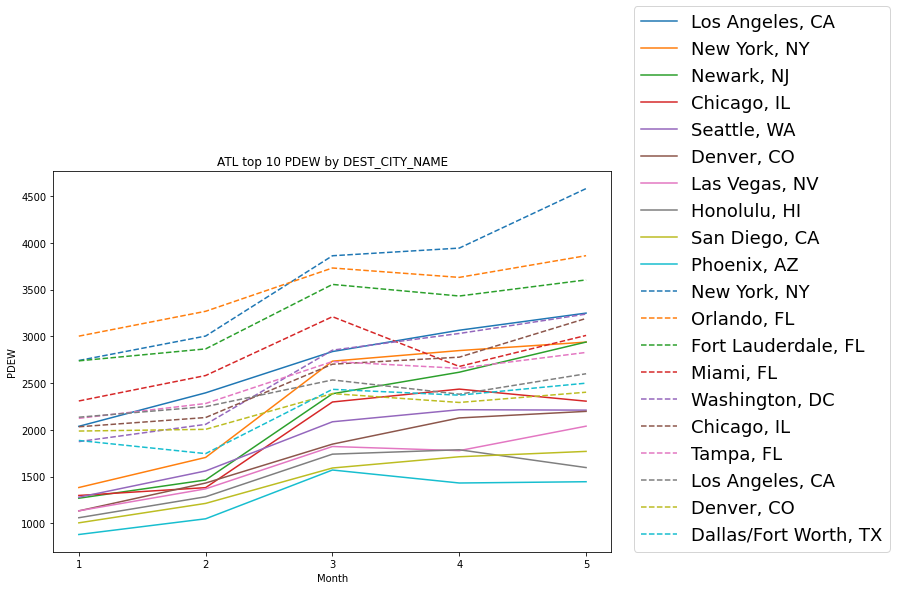

In [7]:
def query_org(airport_code):
    city_data = data[data.ORIGIN == airport_code].sort_values(
        ['PEWD'], ascending=False)
    return city_data


def pivot_org(data, category):
    data_pivot = round(pd.pivot_table(data, columns=['MONTH'], index=[
        category], values=['PEWD'], aggfunc='sum', margins=True, margins_name='Total').dropna(), 2)
    rank = data_pivot['PEWD'].sort_values(
        by='Total', ascending=False).drop('Total')
    return rank


def plot(data, airport_code, category, linestyle):
    A = data.drop('Total', axis=1)
    A = A.T
    plt.ylabel('PEWD')
    plt.xlabel('Month')
    plt.xticks([i for i in range(1, 13)])
    for i in A.columns:
        plt.plot(A.index, A[i], label=A[i].name, linestyle=linestyle)

    plt.legend(fontsize=18, loc=(1.04, 0))
    plt.rcParams["figure.figsize"] = (10, 7)
    plt.title(f'{airport_code} top 10 PEWD by {category}')


linestyle = 'solid'
airport_code = 'SFO'
city = query_org(airport_code)
category = 'DEST_CITY_NAME'
res = pivot_org(city, category)
top = res.head(10)
res.head(10)
plot(top, airport_code, category, linestyle)

linestyle1 = 'dashed'
airport_code = 'ATL'
city = query_org(airport_code)
category = 'DEST_CITY_NAME'
res = pivot_org(city, category)
top = res.head(10)
res.head(10)
plot(top, airport_code, category, linestyle1)


In [4]:
# City pair pax per day table
city_pair = data.query(
    """ (`ORIGIN` == 'SFO' or `ORIGIN` == 'BNA') and `DEST` == 'LAX' and `CLASS` == 'F' """)

data_pivot = round(pd.pivot_table(city_pair, columns=['MONTH'], index=['ORIGIN',
     'CARRIER_NAME'], values=['PEWD'], aggfunc='sum', margins=True, margins_name='Total'), 2)
rank = data_pivot['PEWD'].sort_values(
    by=['ORIGIN', 'Total'], ascending=False).drop('Total')
# plot(top, org_code, category, linestyle)
rank


C:\Users\namek\AppData\Local\Temp\ipykernel_5312\1030940337.py:8: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  by=['ORIGIN', 'Total'], ascending=False).drop('Total')


MONTH                               1       2        3        4        5  \
ORIGIN CARRIER_NAME                                                        
SFO    SkyWest Airlines Inc.   731.17  735.16  1009.40  1058.64  1163.87   
       United Air Lines Inc.   622.63  758.70   956.18   959.31   904.35   
       Southwest Airlines Co.  234.30  286.77   383.83   564.70   587.53   
       Alaska Airlines Inc.    250.63  372.78   339.41   241.83   344.00   
       JetBlue Airways         128.43  155.63   141.00   240.13   249.87   
       American Airlines Inc.   56.87   86.00     6.93      NaN      NaN   
       Horizon Air               7.90     NaN      NaN      NaN      NaN   
       Delta Air Lines Inc.      6.80     NaN      NaN      NaN      NaN   
BNA    Southwest Airlines Co.  221.56  246.23   157.50   284.90   315.30   
       Delta Air Lines Inc.    114.60  119.80   300.00   338.20   320.80   
       American Airlines Inc.  137.57  130.93   150.80   155.34   173.20   
       Spirit Air Lines         76.20   63.60    71.53    68.93   102.20   
       JetBlue Airways            NaN     NaN      NaN      NaN     5.23   

MONTH                            Total  
ORIGIN CARRIER_NAME                     
SFO    SkyWest Airlines Inc.   4698.24  
       United Air Lines Inc.   4201.17  
       Southwest Airlines Co.  2057.13  
       Alaska Airlines Inc.    1548.65  
       JetBlue Airways          915.06  
       American Airlines Inc.   149.80  
       Horizon Air                7.90  
       Delta Air Lines Inc.       6.80  
BNA    Southwest Airlines Co.  1225.49  
       Delta Air Lines Inc.    1193.40  
       American Airlines Inc.   747.84  
       Spirit Air Lines         382.46  
       JetBlue Airways            5.23

In [5]:
# DISCLAIMER: 'df' refers to the data you passed in when calling 'dtale.show'

# TOP Ten SFO Destination by load factor and airline
if isinstance(df, (pd.DatetimeIndex, pd.MultiIndex)):
	df = df.to_frame(index=False)

# remove any pre-existing indices for ease of use in the D-Tale code, but this is not required
df = df.reset_index().drop('index', axis=1, errors='ignore')
# update columns to strings in case they are numbers
df.columns = [str(c) for c in df.columns]

df = df[[c for c in df.columns if c not in ['PAYLOAD']]]
df = df[[c for c in df.columns if c not in ['DEPARTURES_SCHEDULED']]]
df = df.query(
	"""`LOAD_FACTOR` < 100 and `QUARTER` == 1 and `MONTH` in (1, 2, 3) and `ORIGIN` == 'SFO'""")

df = df.sort_values(['LOAD_FACTOR'], ascending=[False])


F - Schedule Passenger Service
(includes Freight/Mail in the Belly)
G - Scheduled ALL Cargo Service
(NO Passengers)
L - Non-Scheduled Passenger Service
(includes Freight/Mail in the Belly)
N - Non-Scheduled Military Passenger Service by U.S. Carriers
(includes Freight/Mail in the Belly)
P - Non-Scheduled ALL Cargo Service
(NO Passengers)
R - Non-Scheduled Military ALL Cargo Service by U.S. Carriers
(NO Passengers)
Q - Non-Scheduled Services by Foreign Carriers
(Other than Charter) 

In [6]:
# import dtale
# d = dtale.show(data)
# d.open_browser()
